In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
from transformers import pipeline
import torch
import time
import matplotlib.pyplot as plt
from collections import Counter

def prepare_data(filepath):
    # Load the dataset
    df = pd.read_csv(filepath)

    # Assuming your CSV has two columns: 'text' and 'label'
    # Modify column names as per your dataset
    texts = df['text'].tolist()
    labels = df['label'].tolist()


    return texts, labels

torch.cuda.is_available()

True

In [12]:
def evaluate_metrics(y_true, y_pred):
    label_counts = Counter(y_true)

    # Printing the count of each label
    print(f"Number of '0' labels: {label_counts[0]}")
    print(f"Number of '1' labels: {label_counts[1]}")

    print("Evaluating Metrics...")
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # AUROC
    y_pred_proba = [1 - p if label == 0 else p for p, label in zip(y_pred, y_true)]  # Probabilities for AUROC
    auroc = roc_auc_score(y_true, y_pred_proba)
    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

    # Plotting the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Human Recall and LLM Recall (assuming human label is '0' and LLM is '1')
    human_recall = tn / (tn + fp) if (tn + fp) != 0 else 0
    llm_recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Average Recall
    avg_recall = (human_recall + llm_recall) / 2

    # Rates
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0





    return {
        "True Positive": tp,
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Human Recall": human_recall,
        "LLM Recall": llm_recall,
        "AvgRecall": avg_recall,
        "False Positive Rate": fpr,
        "True Negative Rate": tnr,
        "False Negative Rate": fnr,
        "F1 Score": f1,
        "AUROC": auroc
    }

In [3]:
# Load the pipeline
classifier = pipeline("text-classification", model="roberta-base", device=0)

# Prepare data
filepath = "/workspace/Senior-Project-I/dataset/12-OpenGPT/preprocessed/OpenGPT.csv"  # Replace with your file path
texts, y_true = prepare_data(filepath)
print("Data Loaded Successfully")


# Classify text
st = time.time()
results = classifier(texts, truncation=True)
et= time.time()

for i in range(5):
    print(f"Result {i+1}: {results[i]}")
y_pred = [int(result['label'].split('_')[-1]) for result in results]
print(f"Classification Done...\nTime Taken: {et-st}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data Loaded Successfully
Result 1: {'label': 'LABEL_1', 'score': 0.5048984289169312}
Result 2: {'label': 'LABEL_1', 'score': 0.5022352933883667}
Result 3: {'label': 'LABEL_1', 'score': 0.5042401552200317}
Result 4: {'label': 'LABEL_0', 'score': 0.5011549592018127}
Result 5: {'label': 'LABEL_1', 'score': 0.5008494853973389}
Classification Done...
Time Taken: 557.2924847602844


Number of '0' labels: 29142
Number of '1' labels: 29395
Evaluating Metrics...


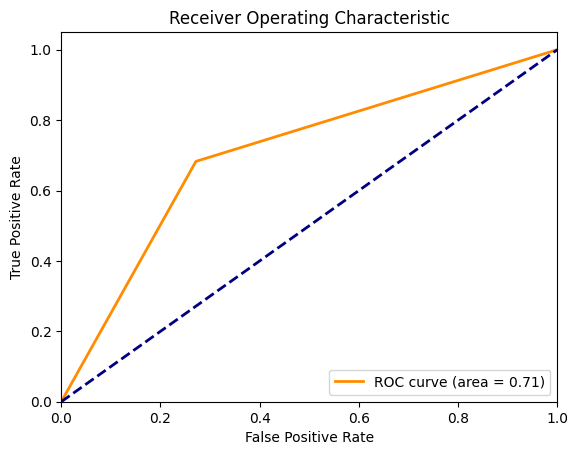

True Positive: 20070.0000
True Negative: 7911.0000
False Positive: 21231.0000
False Negative: 9325.0000
Accuracy: 0.4780
Precision: 0.4859
Recall: 0.6828
Human Recall: 0.2715
LLM Recall: 0.6828
AvgRecall: 0.4771
False Positive Rate: 0.7285
True Negative Rate: 0.2715
False Negative Rate: 0.3172
F1 Score: 0.5678
AUROC: 0.7057


In [13]:
metrics = evaluate_metrics(y_true, y_pred)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")